In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '/home/vincentv/dtaijupiter/projects/anomatools/anomatools/')

# Generate data

Generate a small toy dataset from 3 multivariate Gaussians. Plot the data.

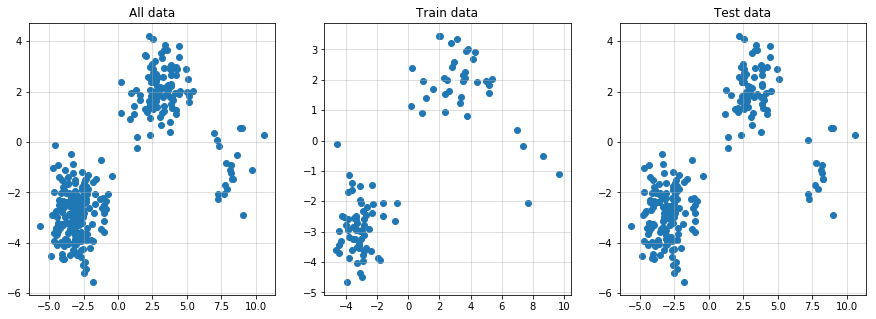

In [3]:
X = np.vstack((np.random.multivariate_normal([-3, -3], [[1, 0], [0, 1]], 200),
               np.random.multivariate_normal([3, 2], [[1, 0], [0, 1]], 100),
               np.random.multivariate_normal([8, -1], [[1, 0], [0, 1]], 20)))
np.random.shuffle(X)
Xtr, Xte = X[:100, :], X[100:, :]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].scatter(X[:, 0], X[:, 1]); axes[0].set_title('All data')
axes[1].scatter(Xtr[:, 0], Xtr[:, 1]); axes[1].set_title('Train data')
axes[2].scatter(Xte[:, 0], Xte[:, 1]); axes[2].set_title('Test data')
for i in range(len(axes)): axes[i].grid(alpha=0.5)

We can clearly see the three clusters in the data. Let's call them: cluster 1, 2, and 3 for respectively the cluster with 100, 50, and 10 instances.

# Detect outliers

## SSkNNO

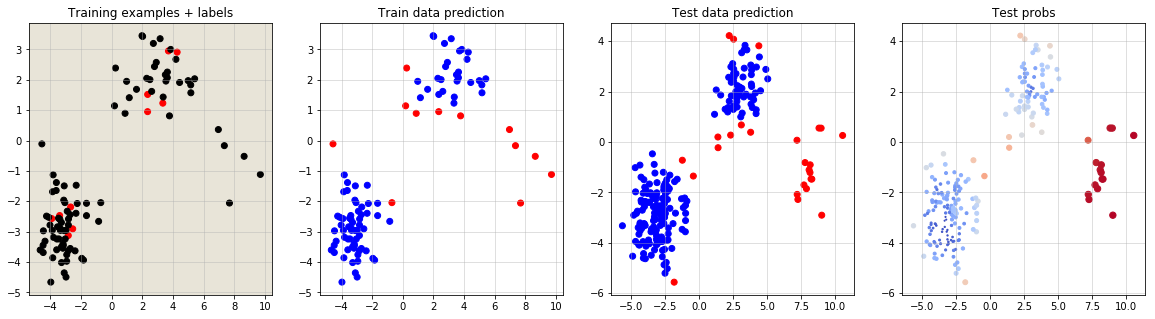

In [4]:
from anomatools.models import SSkNNO

# labels
y = np.zeros(len(Xtr))
y[:10] = 1

detector = SSkNNO(k=10, contamination=0.1, weighted=False)
ytr = detector.fit_predict(Xtr, y)
yte = detector.predict(Xte)
test_probs = detector.predict_proba(Xte, method='linear')[:, 1]  # anomaly probabilities

# plot the predictions
color_code = {0: 'black', 1: 'red', -1: 'blue'}
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].scatter(Xtr[:, 0], Xtr[:, 1], c=[color_code[i] for i in y]); axes[0].set_title('Training examples + labels'); axes[0].set_facecolor('#e8e4d8')
axes[1].scatter(Xtr[:, 0], Xtr[:, 1], c=[color_code[i] for i in ytr]); axes[1].set_title('Train data prediction')
axes[2].scatter(Xte[:, 0], Xte[:, 1], c=[color_code[i] for i in yte]); axes[2].set_title('Test data prediction')
axes[3].scatter(Xte[:, 0], Xte[:, 1], s=test_probs*40, c=test_probs, cmap=plt.cm.coolwarm); axes[3].set_title('Test probs')
for i in range(len(axes)): axes[i].grid(alpha=0.5)

## SSDO

### SSDO with SSDO prior

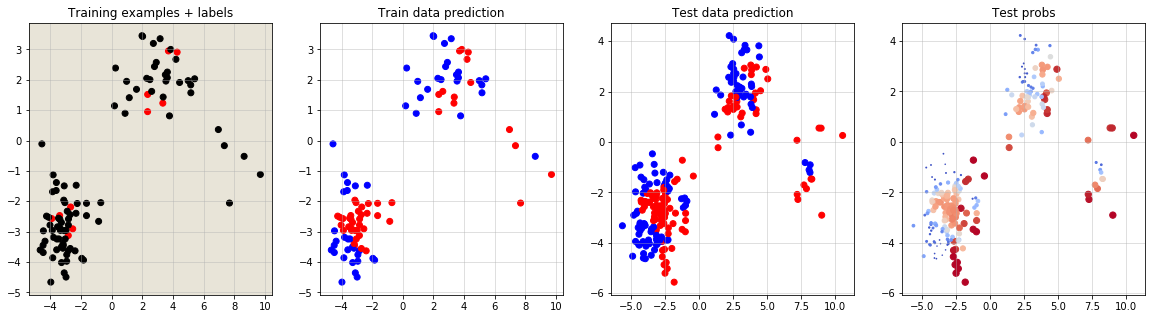

In [5]:
from anomatools.models import SSDO

# labels
y = np.zeros(len(Xtr))
y[:10] = 1

detector = SSDO(k=3, alpha=2.3)
ytr = detector.fit_predict(Xtr, y)
yte = detector.predict(Xte)
test_probs = detector.predict_proba(Xte, method='linear')[:, 1]  # anomaly probabilities

# plot the predictions
color_code = {0: 'black', 1: 'red', -1: 'blue'}
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].scatter(Xtr[:, 0], Xtr[:, 1], c=[color_code[i] for i in y]); axes[0].set_title('Training examples + labels'); axes[0].set_facecolor('#e8e4d8')
axes[1].scatter(Xtr[:, 0], Xtr[:, 1], c=[color_code[i] for i in ytr]); axes[1].set_title('Train data prediction')
axes[2].scatter(Xte[:, 0], Xte[:, 1], c=[color_code[i] for i in yte]); axes[2].set_title('Test data prediction')
axes[3].scatter(Xte[:, 0], Xte[:, 1], s=test_probs*40, c=test_probs, cmap=plt.cm.coolwarm); axes[3].set_title('Test probs')
for i in range(len(axes)): axes[i].grid(alpha=0.5)

### SSDO with Isolation Forest prior

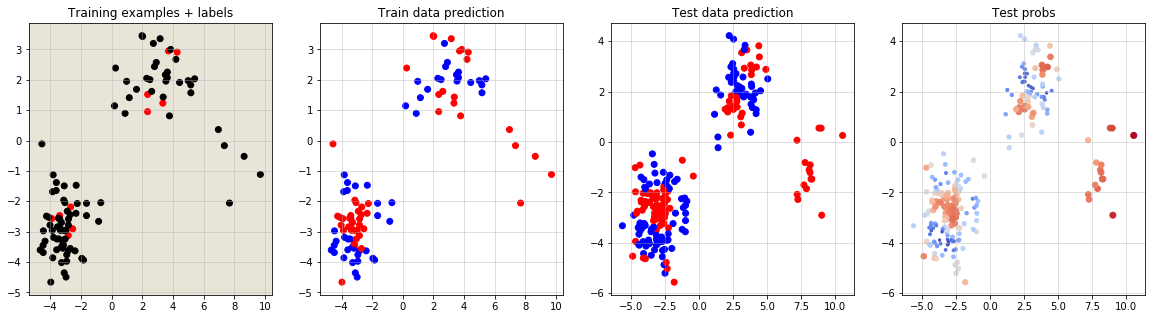

In [6]:
from anomatools.models import SSDO
from sklearn.ensemble import IsolationForest

# labels
y = np.zeros(len(Xtr))
y[:10] = 1

# priors
prior_detector = IsolationForest(contamination=0.1, behaviour='new').fit(Xtr)
train_prior = prior_detector.decision_function(Xtr) * -1
test_prior = prior_detector.decision_function(Xte) * -1
train_prior = train_prior + abs(min(train_prior))
test_prior = test_prior + abs(min(test_prior))

# SSDO
detector = SSDO(k=3, alpha=2.3, unsupervised_prior='other')
ytr = detector.fit_predict(Xtr, y, prior=train_prior)
yte = detector.predict(Xte, prior=test_prior)
test_probs = detector.predict_proba(Xte, prior=test_prior, method='linear')[:, 1]  # anomaly probabilities

# plot the predictions
color_code = {0: 'black', 1: 'red', -1: 'blue'}
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].scatter(Xtr[:, 0], Xtr[:, 1], c=[color_code[i] for i in y]); axes[0].set_title('Training examples + labels'); axes[0].set_facecolor('#e8e4d8')
axes[1].scatter(Xtr[:, 0], Xtr[:, 1], c=[color_code[i] for i in ytr]); axes[1].set_title('Train data prediction')
axes[2].scatter(Xte[:, 0], Xte[:, 1], c=[color_code[i] for i in yte]); axes[2].set_title('Test data prediction')
axes[3].scatter(Xte[:, 0], Xte[:, 1], s=test_probs*40, c=test_probs, cmap=plt.cm.coolwarm); axes[3].set_title('Test probs')
for i in range(len(axes)): axes[i].grid(alpha=0.5)

### SSDO visualizations

In [7]:
from utils.plotting import *

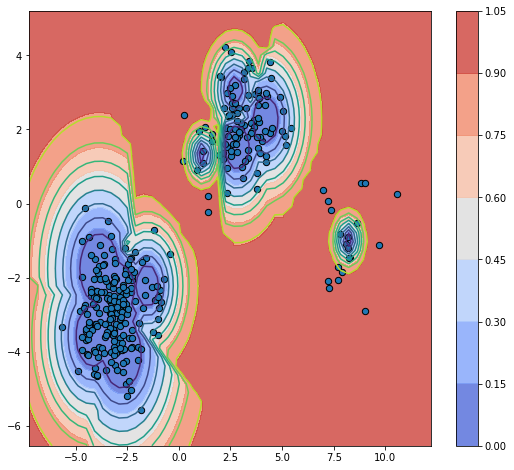

In [8]:
# SSDO
detector = SSDO(k=10, contamination=0.1, unsupervised_prior='ssdo')
plot_2D_classifier(detector, X, np.zeros(len(X)), figure_size=(9, 8))